In [1]:
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces

import imageio
import os
import random

from Dueling_DQN_Agent.Dueling_DQN_Agent import Dueling_DQN_Agent
import Dueling_DQN_Agent.utils.help_classes as hc
import Dueling_DQN_Agent.utils.stats_functions as sf

import hockey.hockey_env as h_env

from importlib import reload

In [2]:
SEED_TRAIN_1 = 7489
SEED_TRAIN_2 = 1312
SEEDS_TEST = [291 + i for i in range(30)]

seed = SEED_TRAIN_1

In [3]:
reload(h_env)
env_name = "Hockey_100000_30000_(256_256_128)_2_vs_nonweak_agent"
env = h_env.HockeyEnv()

state_space = env.observation_space
action_space = env.discrete_action_space

agent = Dueling_DQN_Agent(state_space, action_space, seed = seed, use_eps_decay = True, hidden_sizes = [256, 256, 128]) 
opponent = h_env.BasicOpponent(weak=False)
agent.Q.load(env_name)
stats, losses = sf.load_stats(env_name)

/home/pablosbl/Documents/GitHub/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/pablosbl/Documents/GitHub/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Network loaded from Hockey_100000_30000_(256_256_128)_2_vs_nonweak_agent/weights/training_finished.pth


/home/pablosbl/Documents/GitHub/hockey-en-mallorca/hockey-env/Dueling_DQN_Agent/QFunction.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.loa

Plot saved at Hockey_100000_30000_(256_256_128)_2_vs_nonweak_agent/stats/plots/returns_plot.png


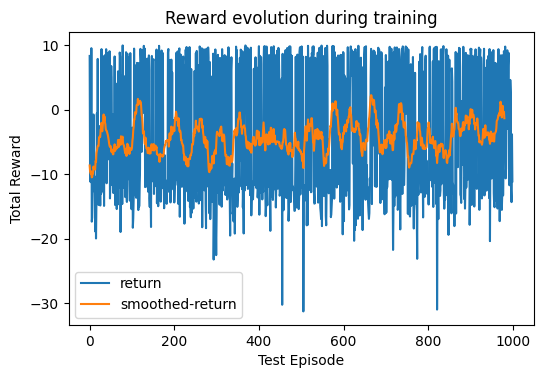

In [4]:
sf.plot_returns(stats, env_name)

Plot saved at Hockey_100000_30000_(256_256_128)_2_vs_nonweak_agent/stats/plots/losses_plot.png


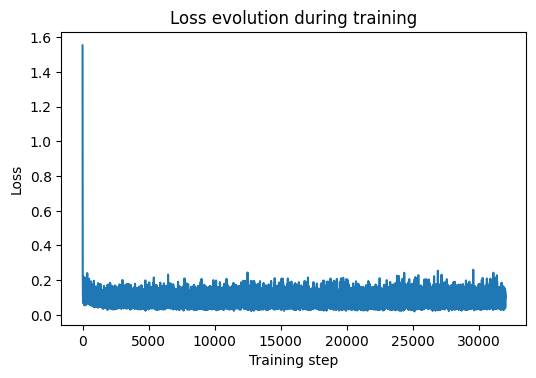

In [5]:
sf.plot_losses(losses, env_name)

Test Episode 1, Total Reward: -11.777767379463576
Test Episode 2, Total Reward: 9.575696797476738
Test Episode 3, Total Reward: -13.492538209702124
Test Episode 4, Total Reward: 9.591983536807804
Test Episode 5, Total Reward: -12.59879897807668
Test Episode 6, Total Reward: 9.601907456401644
Test Episode 7, Total Reward: -11.41528633840771
Test Episode 8, Total Reward: 9.496382955729551
Test Episode 9, Total Reward: -11.537398639905245
Test Episode 10, Total Reward: 9.599721824287048
Test Episode 11, Total Reward: -13.076205337188355
Test Episode 12, Total Reward: 9.512787429758859
Test Episode 13, Total Reward: -11.679112983495562
Test Episode 14, Total Reward: 8.97165053307572
Test Episode 15, Total Reward: 5.915519896053967
Test Episode 16, Total Reward: -3.4497809164827813
Test Episode 17, Total Reward: -11.949623016094025
Test Episode 18, Total Reward: 9.608634324478635
Test Episode 19, Total Reward: -11.499193868745511
Test Episode 20, Total Reward: -28.275904445688315
Test Episo

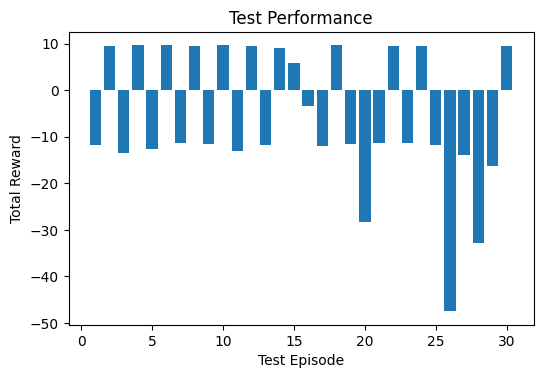

In [7]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

max_steps = 1000

opponent = h_env.BasicOpponent()

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        #a1 = env.discrete_to_continous_action(agent.perform_greedy_action(state))
        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)
        full_action = np.hstack([env.discrete_to_continous_action(a1), a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        agent.buffer.add_transition((state, a1, reward, next_state, done))      # Store transition in the agent"s memory and then train

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs_2/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards)